<a href="https://colab.research.google.com/github/dejiandrew/nba-award-predictor/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline for Final Notebook:

1. Data Pipeline
2. EDA
3. Training LightGBM Model
4. Training Logistic Regression Model
5. Training Neural Network
6. Summary

**NBA Award Predictor: Data Pipeline**

Data pipeline code can be found at https://github.com/dejiandrew/nba-award-predictor/tree/main/data_pipeline

# Pipeline Architecture

Complete data flow from source to machine-learning-ready features:

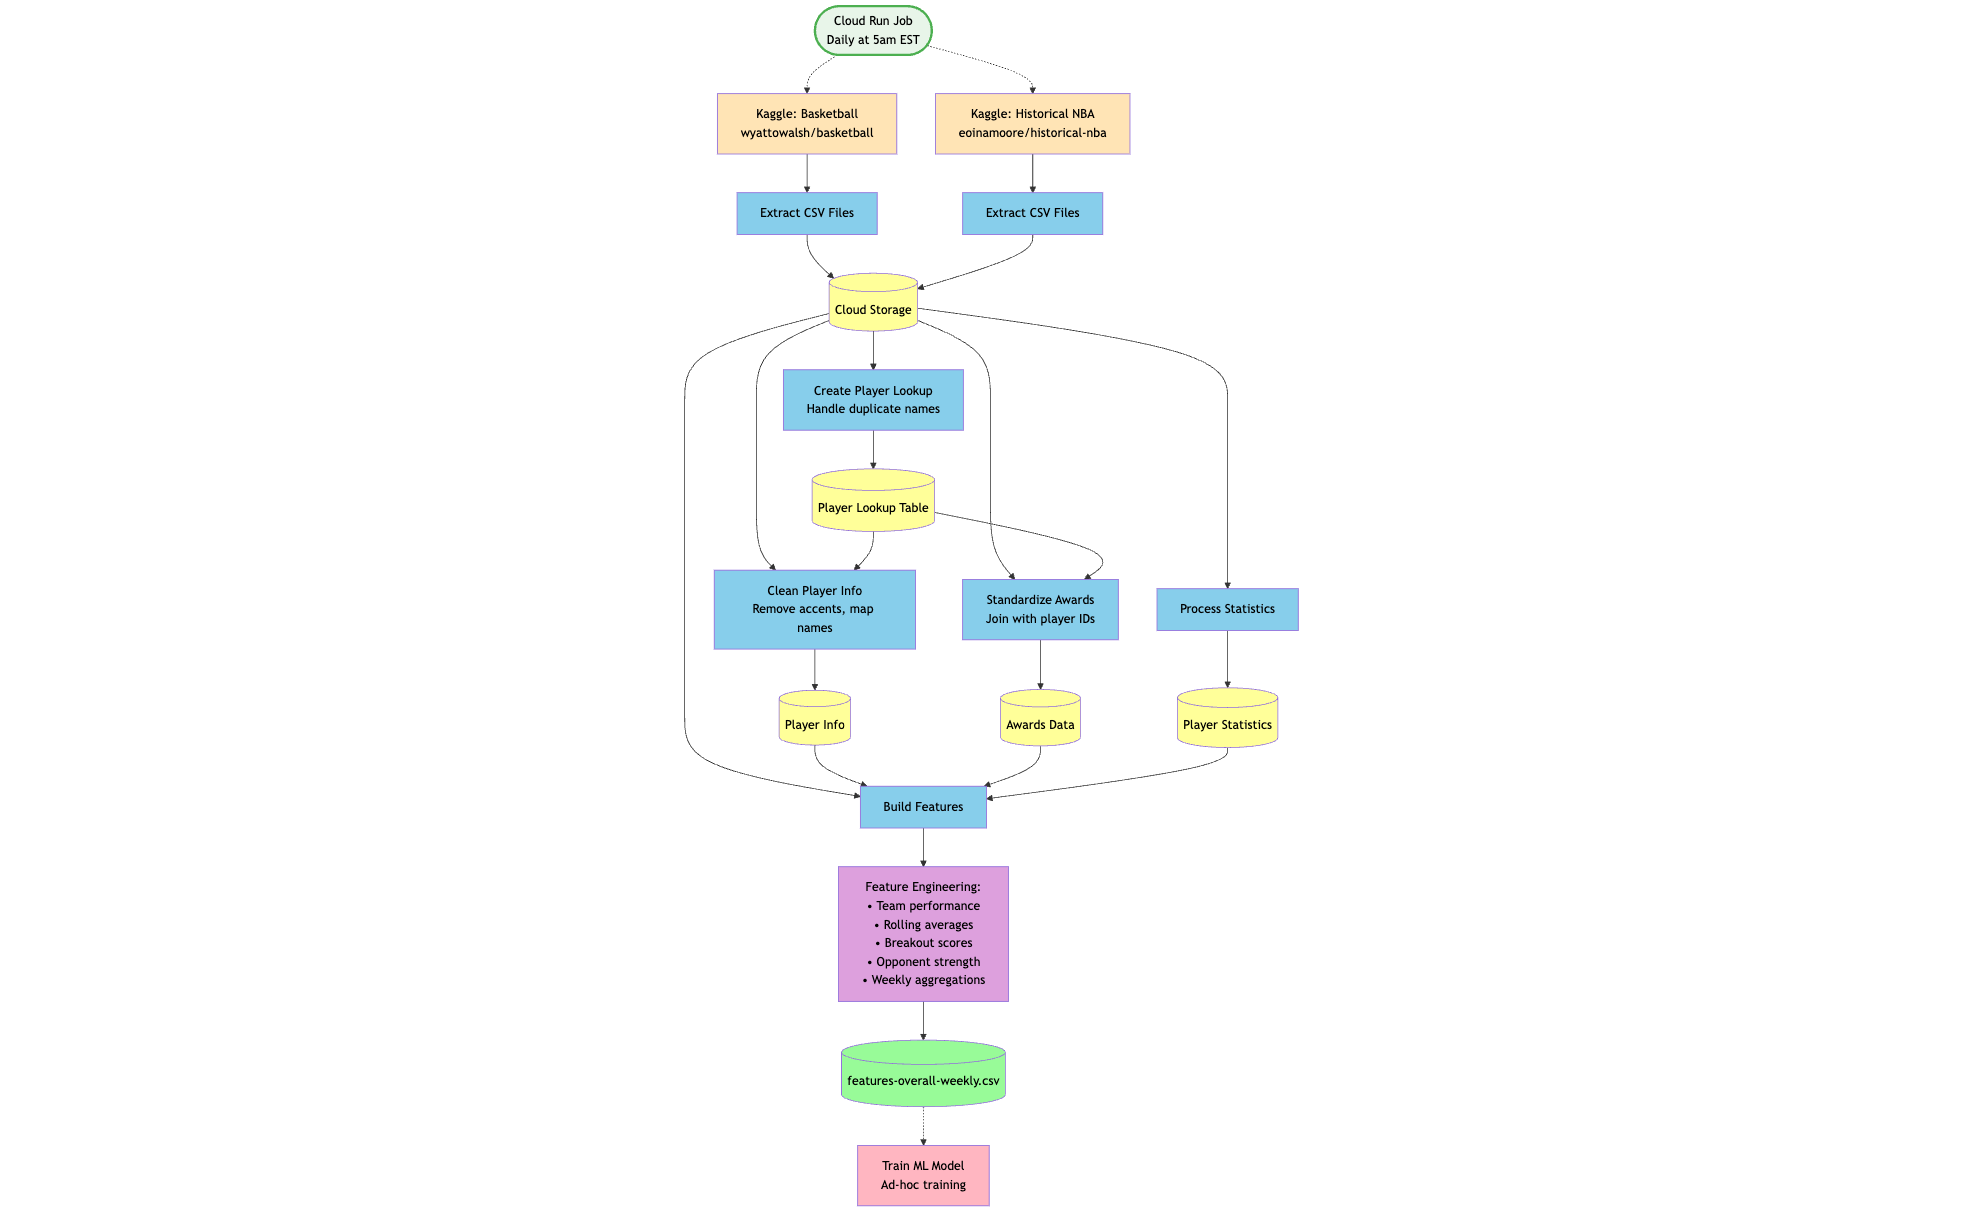

# Key Components

## 1\. Trigger Mechanism

**Cloud Run Job - Daily at 5am EST**

The pipeline executes automatically every day at 5:00 AM EST via a Google Cloud Run Job. This ensures the data remains current and the feature sets reflect the latest NBA games and statistics.

## 2\. Data Sources

**Kaggle - wyattowalsh/basketball:** Comprehensive SQLite database containing historical NBA data including games, teams, and play-by-play information

**Kaggle - eoinamoore/historical-nba:** Detailed player box scores and historical statistics

**RealGM - NBA Awards:** Full list of Player of the Week winners & All-NBA selections

**Wikipedia - List of NBA All Stars:** Full list of all NBA All-Star teams

**NBA API**: baseline data source for player_id values

## 3\. Processing Stages

### Stage 1: Data Extraction

Both Kaggle datasets are downloaded and their CSV files are extracted. The SQLite database from the first dataset is converted to CSV format for consistency. All raw files are uploaded to Google Cloud Storage for persistent storage and downstream processing.

### Stage 2: Data Cleaning & Standardization

This stage addresses the fundamental challenge of integrating data from diverse sources: Wikipedia (All-Star data), RealGM.com (Player of the Week, All-NBA teams), and Kaggle datasets (NBA API statistics). Each source uses different naming conventions, requiring a sophisticated player ID standardization system. See the "Player ID Standardization System" section below for complete technical details on the attach_player_ids() helper function that solves this challenge.

**Create Player Lookup:** Establishes the authoritative player identity system using the NBA API. Handles duplicate names by explicitly disambiguating players like Mike Dunleavy Sr./Jr., Patrick Ewing Sr./Jr., Eddie Johnson variants, etc. Produces nba_player_lookup.csv as the single source of truth for player IDs.

**Clean Player Info:** Normalizes international player names by removing accent marks (Đ→D, Ł→L, Ø→O, etc.) and applies manual name mappings to handle edge cases. This ensures consistent matching across heterogeneous data sources. Produces common-player-info.csv.

**Standardize Awards:** Processes Player of the Week, All-Star, MVP, and All-NBA team data from Wikipedia and RealGM.com. Applies the attach_player_ids() helper function to assign consistent NBA API player IDs to these external sources. This enables seamless joining with statistical data in later stages. Produces player-of-the-week.csv and related award files.

**Process Statistics:** Standardizes data types, handles null values, and produces player-statistics.csv.

### Stage 3: Feature Engineering

**Feature Engineering Components:**

**1\. Team Performance Metrics:** Calculates season-to-date win/loss records, home/away splits, win streaks, and weekly performance. All metrics use "prior" calculations (excluding current game) to prevent data leakage.

**2\. Rolling Averages:** Computes expanding statistics for points, assists, and plus-minus for each player-season. Uses shift() to ensure only historical data informs current predictions.

**3\. Breakout Scores:** Identifies exceptional performance by calculating z-scores: (current_performance - historical_mean) / historical_std. Combines multiple metrics with weights: 0.5×points + 0.3×assists + 0.2×plus-minus. High scores (>2.0) indicate players performing significantly above their averages.

**4\. Opponent Strength:** Measures quality of competition by tracking opponent win rates, wins against teams with >50% records, and wins against rosters containing All-NBA players. Recognizes that beating strong opponents matters more than raw win totals.

**5\. Weekly Aggregations:** Aggregates individual game statistics to the weekly level (Monday-Sunday) to match the Player of the Week award timeframe. Includes sum statistics (points, assists, blocks, steals), count statistics (games played, wins), and average statistics (opponent quality metrics).

## 4\. Pipeline Output

**Dataset for ML Modeling: features-overall-weekly.csv**

The pipeline produces a weekly-aggregated dataset (features-overall-weekly.csv) where each row represents one player's performance for one week. This dataset includes:

- Player and team identifiers
- Temporal features (season, week, date)
- Performance statistics (points, assists, rebounds, etc.)
- Team performance metrics (record, win streaks)
- Opponent quality indicators
- Historical comparison metrics (z-scores, breakout scores)
- Target variable: won_player_of_the_week (binary)

# Technical Spotlight

## Player ID Standardization System

A critical challenge in this project was integrating data from multiple sources that used different player naming conventions. Award data came from Wikipedia (All-Star selections) and RealGM.com (Player of the Week, All-NBA teams). Statistical data came from Kaggle datasets sourced from the official NBA API. Each source had its own approach to player names, creating a complex data integration problem.

**Core Challenge: Name Variations and Ambiguity**

Player names appeared differently across data sources for several reasons:

- Formatting differences: "J.R. Smith" vs. "JR Smith", "C.J. McCollum" vs. "CJ McCollum"
- Nickname variations: "Penny Hardaway" vs. "Anfernee Hardaway", "Tiny Archibald" vs. "Nate Archibald"
- Suffix inconsistencies: "Jimmy Butler" vs. "Jimmy Butler III", "Kenyon Martin Jr." vs. "KJ Martin"
- International name ordering: "Jianlian Yi" vs. "Yi Jianlian", "Yue Sun" vs. "Sun Yue"
- Unusual nicknames: "Fat Lever" for Lafayette Lever, "World B. Free" for World Free
- Identical names requiring disambiguation: Multiple players named "Mike James", "Eddie Johnson", "Steve Smith", etc.

**Solution: name_mappings.csv Lookup Table**

To solve these inconsistencies, we created a manually curated lookup table (name_mappings.csv) through extensive research on Basketball-Reference.com. This table contains three critical columns:

**in_table_name:** How the player name appears in raw data sources (Kaggle, Wikipedia, RealGM)

**nba_lookup_name:** The standardized name from the NBA API (nba_player_lookup.csv)

**player_id:** The unique NBA API player ID that serves as the definitive identifier

**Example Mappings:**

The table resolves complex cases that automated methods would miss:

- "Jimmy Butler" → "Jimmy Butler III" (player_id: 202710)
- "Penny Hardaway" → "Anfernee Hardaway" (player_id: 358)
- "Fat Lever" → "Lafayette Lever" (player_id: 77376)
- "Jianlian Yi" → "Yi Jianlian" (player_id: 201146)
- "Mike Dunleavy, Sr." → "Mike Dunleavy Sr." (player_id: 2399)
- "Eddie Johnson, Jr." → "Eddie L. Johnson" (player_id: 77144) - distinguishes from Eddie A. Johnson

Each entry in this lookup table was researched and added manually by cross-referencing Basketball-Reference.com to verify player identities and resolve ambiguities.

**The Implementation: attach_player_ids() Helper Function**

With the name_mappings.csv lookup table established, a reusable helper function was developed that takes any DataFrame containing player names and adds standardized player_id values from the NBA API.

**Function Workflow:**

**1\. Step 1 - Accent Removal:** Applies the remove_accents() function to normalize all player names to ASCII, handling international players with special characters (Đ, Ł, Ø, Æ, ß, etc.). This ensures consistent string matching regardless of character encoding.

**2\. Step 2 - Name Mapping Join:** Performs two LEFT JOINs with name_mappings.csv:  
• First join matches on in_table_name (catches names as they appear in raw source data)  
• Second join matches on nba_lookup_name (catches names already in NBA API format)  
• Uses CASE logic to prefer the standardized nba_lookup_name if found, otherwise keeps original name  
• This dual-join approach maximizes match rate while handling edge cases

**3\. Step 3 - Player ID Assignment:** LEFT JOINs the result with nba_player_lookup.csv (the authoritative NBA API-based lookup) to assign player_id values. Uses CASE logic with fallback hierarchy to handle scenarios where multiple ID columns exist from the joins, ensuring every player gets the correct unique identifier.

**4\. Step 4 - Cleanup and Standardization:** Removes redundant columns created during joins, renames final columns to standardized names (player_name, player_id), reorders columns to place player identifiers first for readability, and deletes temporary lookup files to conserve disk space.

**Impact and Reusability:**

This helper function was applied to all external data sources (Wikipedia All-Star data, RealGM Player of the Week, RealGM All-NBA teams) to establish a consistent player_id primary key across all datasets. The function's design makes it reusable for any future data sources that need player ID standardization - simply pass in a DataFrame and specify the column containing player names.

## Storage Architecture

**Why CSV in Google Cloud Storage?**

The pipeline stores all processed data as CSV files in GCS for several strategic reasons:

- Universal compatibility with Pandas, DuckDB, and other data tools
- Easy access from any environment (local, Colab, cloud instances) via simple downloads
- No schema evolution complications - columns can be added/removed easily
- Persistent storage survives pipeline execution environment termination

**The below code represents the Feature Engineering portion of our workflow. This code gathers player info, awards data, and player statistics to conduct Feature Engineering**

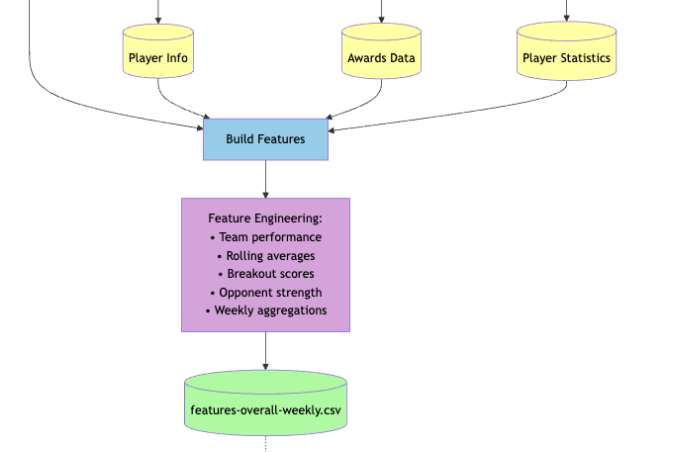

In [7]:
import pandas as pd
import numpy as np
import duckdb
import wget
import os
from google.cloud import storage
import gc

# Download CSV files
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/nba-all-stars.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/nba-mvp.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/all-nba-first-team.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/all-nba-second-team.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/all-nba-third-team.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/player-of-the-week.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/player-statistics.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/games.csv')

# Kaggle source data changed the gameDate column name to gameDateTimeEst on 11/24/25. This code reverts the column back to gameDate.
games_df = pd.read_csv('games.csv')
query = """
SELECT
gameId
,CAST(gameDateTimeEst AS DATE) AS gameDate
,hometeamCity
,hometeamName
,hometeamId
,awayteamCity
,awayteamName
,awayteamId
,homeScore
,awayScore
,winner
,gameType
,attendance
,arenaId
,gameLabel
,gameSubLabel
,seriesGameNumber
FROM games_df

"""
games_df = duckdb.query(query).df()
games_df.to_csv('games.csv')

def build_team_games(df, filter=None):
    df = df.copy()

    # Parse datetime with mixed formats
    df['gamedate'] = pd.to_datetime(
        df['gamedate'],
        utc=True,
        errors='coerce',
        format='mixed',
        dayfirst=True,
    )

    if filter:
        df = df.query(filter)

    # Normalize: make two rows per game (home + away)
    home = df.rename(columns={
        'hometeamname': 'team',
        'hometeamid':   'teamid',
        'homescore':    'team_score',
        'awayscore':    'opp_score'
    })[['gameid','gamedate','team','teamid','team_score','opp_score','winner',
        'awayteamname','awayteamid']].assign(
            home = 1,
            opponent  = lambda x: x['awayteamname'],
            opponentid= lambda x: x['awayteamid'],
        ).drop(columns=['awayteamname','awayteamid'])

    away = df.rename(columns={
        'awayteamname': 'team',
        'awayteamid':   'teamid',
        'awayscore':    'team_score',
        'homescore':    'opp_score'
    })[['gameid','gamedate','team','teamid','team_score','opp_score','winner',
        'hometeamname','hometeamid']].assign(
            home = 0,
            opponent  = lambda x: x['hometeamname'],
            opponentid= lambda x: x['hometeamid'],
        ).drop(columns=['hometeamname','hometeamid'])

    long = pd.concat([home, away], ignore_index=True)

    # Outcome flags
    long['is_win']  = (long['teamid'] == long['winner']).astype(int)
    long['outcome'] = long['is_win'].map({1: 'win', 0: 'loss'})
    long['is_home_win'] = ((long['home'] == 1) & (long['is_win'] == 1)).astype(int)
    long['is_away_win'] = ((long['home'] == 0) & (long['is_win'] == 1)).astype(int)

    # Season (season starts in July)
    year = long['gamedate'].dt.year
    month = long['gamedate'].dt.month
    long['season'] = np.where(month >= 7, year, year - 1)

    # Sort for rolling calculations
    long = long.sort_values(['teamid', 'season', 'gamedate', 'gameid'], kind='mergesort')

    # Group by team + season for all season-based stats
    g = long.groupby(['teamid', 'season'], group_keys=False)

    # Games played prior (per season)
    long['games_prior'] = g.cumcount()

    # Wins / losses prior (per season)
    long['wins_prior'] = g['is_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )
    long['losses_prior'] = long['games_prior'] - long['wins_prior']

    # Home / away games prior (per season)
    long['home_games_prior'] = g['home'].transform(
        lambda s: s.shift(fill_value=0).cumsum()
    )
    long['away_games_prior'] = long['games_prior'] - long['home_games_prior']

    # Home / away wins prior (per season)
    long['home_wins_prior'] = g['is_home_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )
    long['away_wins_prior'] = g['is_away_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )

    # Home / away losses prior (per season)
    long['home_losses_prior'] = long['home_games_prior'] - long['home_wins_prior']
    long['away_losses_prior'] = long['away_games_prior'] - long['away_wins_prior']

    # Win streaks prior (per season)
    def streak_prior(series):
        prior = series.shift().fillna(0).astype(int)
        # reset when we see a 0
        return prior.groupby((prior == 0).cumsum()).cumsum().astype(int)

    long['win_streak_prior'] = g['is_win'].transform(streak_prior)
    long['home_win_streak_prior'] = g['is_home_win'].transform(streak_prior)
    long['away_win_streak_prior'] = g['is_away_win'].transform(streak_prior)

    # Record strings (per season)
    long['record_prior'] = long['wins_prior'].astype(str) + '-' + long['losses_prior'].astype(str)
    long['home_record_prior'] = long['home_wins_prior'].astype(str) + '-' + long['home_losses_prior'].astype(str)
    long['away_record_prior'] = long['away_wins_prior'].astype(str) + '-' + long['away_losses_prior'].astype(str)

    # Opponent's prior record for same game (still season-based because wins_prior/losses_prior are)
    opp_prior = long[['gameid','teamid','wins_prior','losses_prior']].rename(
        columns={
            'teamid': 'opponentid',
            'wins_prior': 'opp_wins_prior',
            'losses_prior': 'opp_losses_prior'
        }
    )

    long = long.merge(opp_prior, on=['gameid','opponentid'], how='left')

    # Opponent winrate prior to the game
    opp_games_prior = long['opp_wins_prior'] + long['opp_losses_prior']
    long['opp_winrate_prior'] = long['opp_wins_prior'] / opp_games_prior.where(opp_games_prior > 0)

    # Flag for wins vs > .500 opponent (per game)
    long['is_win_vs_over_500'] = (
        (long['is_win'] == 1) &
        (long['opp_winrate_prior'] > 0.5)
    ).astype(int)

    # Per-team, per-season cumulative PRIOR wins vs > .500
    long['wins_vs_over_500_prior'] = (
        long.groupby(['teamid', 'season'])['is_win_vs_over_500']
            .transform(lambda s: s.shift().fillna(0).cumsum().astype(int))
    )

    # Week-based (Mon–Sun) record PRIOR, per-season
    iso = long['gamedate'].dt.isocalendar()
    long['week_year'] = iso['year']
    long['week_num']  = iso['week']

    gw = long.groupby(['teamid','season','week_year','week_num'], group_keys=False)

    long['week_games_prior'] = gw.cumcount()
    long['week_wins_prior'] = gw['is_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )
    long['week_losses_prior'] = long['week_games_prior'] - long['week_wins_prior']

    long['week_record_prior'] = (
        long['week_wins_prior'].astype(str)
        + '-' +
        long['week_losses_prior'].astype(str)
    )

    # Final output
    out = long[['gameid','gamedate',
                'team','teamid',
                'opponent','opponentid',
                'outcome','home',
                'team_score','opp_score',
                'games_prior','wins_prior','losses_prior','record_prior',
                'home_games_prior','home_wins_prior','home_losses_prior','home_record_prior',
                'away_games_prior','away_wins_prior','away_losses_prior','away_record_prior',
                'win_streak_prior','home_win_streak_prior','away_win_streak_prior',
                'opp_wins_prior','opp_losses_prior','opp_winrate_prior',
                'is_win_vs_over_500','wins_vs_over_500_prior',
                'week_games_prior','week_wins_prior','week_losses_prior','week_record_prior',
                'season'
            ]]
    out.loc[:, 'gameid'] = out['gameid'].astype(int)
    out = out.rename(columns={'gameid': 'gameId'})

    return out.sort_values(['gamedate','gameId','home']).reset_index(drop=True)

def wins_vs_all_nba(first,second,third,stats):
    stats.rename(columns={"gameId": "game_id"}, inplace=True)
    all_nba = pd.concat([first, second, third], ignore_index=True)
    all_nba_player_ids = set(all_nba["player_id"].unique())

    rosters = (
        stats
        .groupby(["game_id", "playerteamName"])["player_id"]
        .apply(set)
        .reset_index()
        .rename(columns={"playerteamName": "team_name", "player_id": "roster"})
    )

    df = stats.merge(
        rosters.rename(columns={"team_name": "playerteamName",
                                "roster": "player_roster"}),
        on=["game_id", "playerteamName"],
        how="left"
    )

    df = df.merge(
        rosters.rename(columns={"team_name": "opponentteamName",
                                "roster": "opponent_roster"}),
        on=["game_id", "opponentteamName"],
        how="left"
    )

    def opponent_has_all_nba(roster):
        if isinstance(roster, set):
            return int(len(roster.intersection(all_nba_player_ids)) > 0)
        return 0

    df["opponent_has_all_nba"] = df["opponent_roster"].apply(opponent_has_all_nba)

    df["wins_vs_team_with_all_nba_player"] = (
        (df["win"] == 1) & (df["opponent_has_all_nba"] == 1)
    ).astype(int)

    df["player_name"] = df["full_name"]

    output = df[[
        "player_id",
        "player_name",
        "game_id",
        "playerteamName",
        "opponentteamName",
        "win",
        "opponent_has_all_nba",
        "wins_vs_team_with_all_nba_player"
    ]].sort_values("game_id").reset_index(drop=True)

    return output

games_df = pd.read_csv('games.csv')
games_df.columns = games_df.columns.str.lower()
game = build_team_games(games_df, "gamedate.dt.year >= 1979")

# The null values in game["opp_winrate_prior"] represent games where the opponent had played zero regular season
# games at that point (e.g. first game of the season). Set game["opp_winrate_prior"] to 0.500 for these rows.
game["opp_winrate_prior"] = game["opp_winrate_prior"].fillna(0.500)


team_info = {
    # Eastern Conference
    'Boston Celtics': {'conference': 'East', 'team_nickname': 'Celtics'},
    'Brooklyn Nets': {'conference': 'East', 'team_nickname': 'Nets'},
    'New York Knicks': {'conference': 'East', 'team_nickname': 'Knicks'},
    'Philadelphia 76ers': {'conference': 'East', 'team_nickname': '76ers'},
    'Philadelphia Sixers': {'conference': 'East', 'team_nickname': 'Sixers'},
    'Toronto Raptors': {'conference': 'East', 'team_nickname': 'Raptors'},
    'Chicago Bulls': {'conference': 'East', 'team_nickname': 'Bulls'},
    'Cleveland Cavaliers': {'conference': 'East', 'team_nickname': 'Cavaliers'},
    'Detroit Pistons': {'conference': 'East', 'team_nickname': 'Pistons'},
    'Indiana Pacers': {'conference': 'East', 'team_nickname': 'Pacers'},
    'Milwaukee Bucks': {'conference': 'East', 'team_nickname': 'Bucks'},
    'Atlanta Hawks': {'conference': 'East', 'team_nickname': 'Hawks'},
    'Charlotte Hornets': {'conference': 'East', 'team_nickname': 'Hornets'},
    'Miami Heat': {'conference': 'East', 'team_nickname': 'Heat'},
    'Orlando Magic': {'conference': 'East', 'team_nickname': 'Magic'},
    'Washington Wizards': {'conference': 'East', 'team_nickname': 'Wizards'},
    'Washington Bullets': {'conference': 'East', 'team_nickname': 'Bullets'},
    'New Jersey Nets': {'conference': 'East', 'team_nickname': 'Nets'},
    'Charlotte Bobcats': {'conference': 'East', 'team_nickname': 'Bobcats'},

    # Western Conference
    'Denver Nuggets': {'conference': 'West', 'team_nickname': 'Nuggets'},
    'Minnesota Timberwolves': {'conference': 'West', 'team_nickname': 'Timberwolves'},
    'Oklahoma City Thunder': {'conference': 'West', 'team_nickname': 'Thunder'},
    'Portland Trail Blazers': {'conference': 'West', 'team_nickname': 'Trail Blazers'},
    'Utah Jazz': {'conference': 'West', 'team_nickname': 'Jazz'},
    'Golden State Warriors': {'conference': 'West', 'team_nickname': 'Warriors'},
    'Los Angeles Clippers': {'conference': 'West', 'team_nickname': 'Clippers'},
    'LA Clippers': {'conference': 'West', 'team_nickname': 'Clippers'},
    'Los Angeles Lakers': {'conference': 'West', 'team_nickname': 'Lakers'},
    'Phoenix Suns': {'conference': 'West', 'team_nickname': 'Suns'},
    'Sacramento Kings': {'conference': 'West', 'team_nickname': 'Kings'},
    'Dallas Mavericks': {'conference': 'West', 'team_nickname': 'Mavericks'},
    'Houston Rockets': {'conference': 'West', 'team_nickname': 'Rockets'},
    'Memphis Grizzlies': {'conference': 'West', 'team_nickname': 'Grizzlies'},
    'New Orleans Pelicans': {'conference': 'West', 'team_nickname': 'Pelicans'},
    'San Antonio Spurs': {'conference': 'West', 'team_nickname': 'Spurs'},
    'Seattle SuperSonics': {'conference': 'West', 'team_nickname': 'SuperSonics'},
    'San Diego Clippers': {'conference': 'West', 'team_nickname': 'Clippers'},
    'Kansas City Kings': {'conference': 'West', 'team_nickname': 'Kings'},
    'New Orleans Hornets': {'conference': 'West', 'team_nickname': 'Hornets'},
    'Vancouver Grizzlies': {'conference': 'West', 'team_nickname': 'Grizzlies'},
    'Oklahoma City Hornets': {'conference': 'West', 'team_nickname': 'Hornets'},
    'New Orleans Jazz': {'conference': 'West', 'team_nickname': 'Jazz'}
}

team_conference_df = pd.DataFrame.from_dict(team_info, orient='index')
team_conference_df.index.name = 'team'
team_conference_df = team_conference_df.reset_index()

pow_df = pd.read_csv('player-of-the-week.csv')

query = """
WITH CTE AS (
SELECT
player_id
,season
,player
,team_conference_df.conference
,(CAST(date AS DATE) - 1) AS date
,DAY(CAST(date AS DATE) - 1) AS day
,WEEK(CAST(date AS DATE) - 1) AS week
,MONTH(CAST(date AS DATE) - 1) AS month
,YEAR(CAST(date AS DATE) - 1) AS year
,pow_df.team
,pos
,height
,weight
,age
,"Pre-Draft Team"
,"Draft Yr"
,yos

FROM pow_df
JOIN team_conference_df
ON pow_df.team = team_conference_df.team
)

SELECT * FROM CTE

"""

pow_df = duckdb.query(query).df()
pow_df = pow_df[['player_id','player','conference','date','day','week','month','year']]

query = """
SELECT
gameId
,CAST(gamedate AS DATE) AS gamedate
,DAY(CAST(gamedate AS DATE)) AS day
,WEEK(CAST(gamedate AS DATE)) AS week
,MONTH(CAST(gamedate AS DATE)) AS month
,YEAR(CAST(gamedate AS DATE)) AS year
,team
,teamid
,opponent
,opponentid
,outcome
,home
,team_score
,opp_score
,games_prior
,wins_prior
,losses_prior
,record_prior
,home_games_prior
,home_wins_prior
,home_losses_prior
,home_record_prior
,away_games_prior
,away_wins_prior
,away_losses_prior
,away_record_prior
,win_streak_prior
,home_win_streak_prior
,away_win_streak_prior
,opp_wins_prior
,opp_losses_prior
,opp_winrate_prior
,is_win_vs_over_500
,wins_vs_over_500_prior
,week_games_prior
,week_wins_prior
,week_losses_prior
,week_record_prior
,season
FROM game
"""

game = duckdb.query(query).df()

query = """

SELECT *
FROM game
JOIN pow_df
ON (game.week = pow_df.week AND game.year = pow_df.year)

"""

combined_df = duckdb.query(query).df()

combined_df = combined_df.rename(columns={'player_id':'pow_player_id','player':'player_of_the_week','conference':'pow_conference','date':'pow_last_date_of_week'})
player_statistics_df = pd.read_csv('player-statistics.csv')
stats = player_statistics_df = pd.read_csv('player-statistics.csv')

player_statistics_df = player_statistics_df[['firstName', 'lastName', 'full_name', 'player_id', 'gameId', 'gameDate', 'playerteamName',
'numMinutes', 'points', 'assists',
    'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
    'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
    'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
    'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
    'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints']]

query = """

SELECT *
FROM combined_df
LEFT JOIN player_statistics_df
ON combined_df.gameId = player_statistics_df.gameId AND combined_df.team = playerteamName
"""

game_and_player_stats_df = duckdb.query(query).df()
# Remove any performances where the player did not play
query = """

SELECT *
FROM game_and_player_stats_df
WHERE numMinutes IS NOT NULL
"""
game_and_player_stats_df = duckdb.query(query).df()


player_statistics_test_df = pd.read_csv('player-statistics.csv')
query = """

SELECT *,
    CASE
        WHEN gameDate BETWEEN '2025-10-02' AND '2026-08-01' THEN 2025
        WHEN gameDate BETWEEN '2024-10-04' AND '2025-06-22' THEN 2024
        WHEN gameDate BETWEEN '2023-10-05' AND '2024-06-17' THEN 2023
        WHEN gameDate BETWEEN '2022-09-30' AND '2023-06-12' THEN 2022
        WHEN gameDate BETWEEN '2021-10-03' AND '2022-06-16' THEN 2021
        WHEN gameDate BETWEEN '2020-12-11' AND '2021-07-20' THEN 2020
        WHEN gameDate BETWEEN '2019-10-22' AND '2020-10-11' THEN 2019
        WHEN gameDate BETWEEN '2018-10-16' AND '2019-06-10' THEN 2018
        WHEN gameDate BETWEEN '2017-09-30' AND '2018-06-08' THEN 2017
        WHEN gameDate BETWEEN '2016-10-01' AND '2017-06-12' THEN 2016
        WHEN gameDate BETWEEN '2015-10-02' AND '2016-06-19' THEN 2015
        WHEN gameDate BETWEEN '2014-10-04' AND '2015-06-16' THEN 2014
        WHEN gameDate BETWEEN '2013-10-05' AND '2014-06-15' THEN 2013
        WHEN gameDate BETWEEN '2012-10-05' AND '2013-06-20' THEN 2012
        WHEN gameDate BETWEEN '2011-12-16' AND '2012-06-21' THEN 2011
        WHEN gameDate BETWEEN '2010-10-03' AND '2011-06-12' THEN 2010
        WHEN gameDate BETWEEN '2009-10-01' AND '2010-06-17' THEN 2009
        WHEN gameDate BETWEEN '2008-10-05' AND '2009-06-11' THEN 2008
        WHEN gameDate BETWEEN '2007-10-06' AND '2008-06-17' THEN 2007
        WHEN gameDate BETWEEN '2006-10-05' AND '2007-06-14' THEN 2006
        WHEN gameDate BETWEEN '2005-10-10' AND '2006-04-19' THEN 2005
        WHEN gameDate BETWEEN '2004-11-02' AND '2005-06-21' THEN 2004
        WHEN gameDate BETWEEN '2003-10-28' AND '2004-06-15' THEN 2003
        WHEN gameDate BETWEEN '2002-10-29' AND '2003-06-15' THEN 2002
        WHEN gameDate BETWEEN '2001-10-30' AND '2002-04-17' THEN 2001
        WHEN gameDate BETWEEN '2000-10-31' AND '2001-06-15' THEN 2000
        WHEN gameDate BETWEEN '1999-11-02' AND '2000-04-19' THEN 1999
        WHEN gameDate BETWEEN '1998-02-05' AND '1999-06-25' THEN 1998
        WHEN gameDate BETWEEN '1997-10-31' AND '1998-06-14' THEN 1997
        WHEN gameDate BETWEEN '1996-11-01' AND '1997-06-13' THEN 1996
        WHEN gameDate BETWEEN '1995-11-03' AND '1996-04-21' THEN 1995
        WHEN gameDate BETWEEN '1994-11-04' AND '1995-06-14' THEN 1994
        WHEN gameDate BETWEEN '1993-11-05' AND '1994-04-24' THEN 1993
        WHEN gameDate BETWEEN '1992-11-06' AND '1993-06-20' THEN 1992
        WHEN gameDate BETWEEN '1991-11-01' AND '1992-06-12' THEN 1991
        WHEN gameDate BETWEEN '1990-11-02' AND '1991-06-12' THEN 1990
        WHEN gameDate BETWEEN '1989-11-03' AND '1990-06-14' THEN 1989
        WHEN gameDate BETWEEN '1988-11-04' AND '1989-06-13' THEN 1988
        WHEN gameDate BETWEEN '1987-11-06' AND '1988-06-19' THEN 1987
        WHEN gameDate BETWEEN '1986-10-31' AND '1987-06-14' THEN 1986
        WHEN gameDate BETWEEN '1985-10-25' AND '1986-06-05' THEN 1985
        WHEN gameDate BETWEEN '1984-10-26' AND '1985-06-09' THEN 1984
        WHEN gameDate BETWEEN '1983-10-28' AND '1984-06-12' THEN 1983
        WHEN gameDate BETWEEN '1982-10-29' AND '1983-05-31' THEN 1982
        WHEN gameDate BETWEEN '1981-10-30' AND '1982-06-06' THEN 1981
        WHEN gameDate BETWEEN '1980-10-10' AND '1981-05-14' THEN 1980
        WHEN gameDate BETWEEN '1979-10-12' AND '1980-05-16' THEN 1979
        WHEN gameDate BETWEEN '1978-10-13' AND '1979-06-01' THEN 1978
        WHEN gameDate BETWEEN '1977-10-18' AND '1978-06-07' THEN 1977
        WHEN gameDate BETWEEN '1976-02-13' AND '1977-06-05' THEN 1976
        WHEN gameDate BETWEEN '1976-02-03' AND '1976-06-06' THEN 1975
        WHEN gameDate BETWEEN '1974-10-17' AND '1975-05-25' THEN 1974
        WHEN gameDate BETWEEN '1973-10-09' AND '1974-05-12' THEN 1973
        WHEN gameDate BETWEEN '1972-10-10' AND '1973-05-10' THEN 1972
        WHEN gameDate BETWEEN '1971-10-12' AND '1972-05-07' THEN 1971
        WHEN gameDate BETWEEN '1971-01-12' AND '1971-04-30' THEN 1970
        WHEN gameDate BETWEEN '1969-10-14' AND '1970-05-08' THEN 1969
        WHEN gameDate BETWEEN '1968-10-15' AND '1969-03-24' THEN 1968
        WHEN gameDate BETWEEN '1967-10-13' AND '1968-05-02' THEN 1967
        WHEN gameDate BETWEEN '1967-01-10' AND '1967-04-24' THEN 1966
        WHEN gameDate BETWEEN '1965-10-15' AND '1966-04-28' THEN 1965
        WHEN gameDate BETWEEN '1964-10-16' AND '1965-03-21' THEN 1964
        WHEN gameDate BETWEEN '1963-10-16' AND '1964-04-26' THEN 1963
        WHEN gameDate BETWEEN '1962-10-19' AND '1963-04-24' THEN 1962
        WHEN gameDate BETWEEN '1961-02-16' AND '1962-04-18' THEN 1961
        WHEN gameDate BETWEEN '1961-01-17' AND '1961-01-17' THEN 1960
        WHEN gameDate BETWEEN '1959-10-18' AND '1960-04-09' THEN 1959
        WHEN gameDate BETWEEN '1958-10-19' AND '1959-03-11' THEN 1958
        WHEN gameDate BETWEEN '1957-10-22' AND '1958-03-12' THEN 1957
        WHEN gameDate BETWEEN '1956-10-27' AND '1957-04-13' THEN 1956
        WHEN gameDate BETWEEN '1955-11-05' AND '1956-04-05' THEN 1955
        WHEN gameDate BETWEEN '1954-10-30' AND '1955-04-10' THEN 1954
        WHEN gameDate BETWEEN '1953-10-30' AND '1954-04-11' THEN 1953
        WHEN gameDate BETWEEN '1952-10-31' AND '1953-04-10' THEN 1952
        WHEN gameDate BETWEEN '1951-11-01' AND '1952-04-23' THEN 1951
        WHEN gameDate BETWEEN '1950-10-31' AND '1951-04-21' THEN 1950
        WHEN gameDate BETWEEN '1949-10-29' AND '1950-04-23' THEN 1949
        WHEN gameDate BETWEEN '1948-11-01' AND '1949-04-13' THEN 1948
        WHEN gameDate BETWEEN '1947-11-12' AND '1948-04-21' THEN 1947
        WHEN gameDate BETWEEN '1946-11-01' AND '1947-04-22' THEN 1946
    END AS season
FROM player_statistics_test_df
"""
player_statistics_test_df = duckdb.query(query).df()

# Bring in all star data
nba_all_stars_df = pd.read_csv('nba-all-stars.csv')
nba_all_stars_df["Season"] = nba_all_stars_df["Selection Year"] - 1
nba_all_stars_df["player_id"] = nba_all_stars_df["player_id"].astype(int)
# Bring in mvp data
nba_mvp_df = pd.read_csv('nba-mvp.csv')
nba_mvp_df["Season"] = nba_mvp_df["Season"].str[:4].astype(int)
# Bring in 1st team all-nba data
all_nba_first_team_df = pd.read_csv('all-nba-first-team.csv')
all_nba_first_team_df["Season"] = all_nba_first_team_df["Season"].str[:4].astype(int)
# Bring in 2nd team all-nba data
all_nba_second_team_df = pd.read_csv('all-nba-second-team.csv')
all_nba_second_team_df["Season"] = all_nba_second_team_df["Season"].str[:4].astype(int)
# Bring in 3rd team all-nba data
all_nba_third_team_df = pd.read_csv('all-nba-third-team.csv')
all_nba_third_team_df["Season"] = all_nba_third_team_df["Season"].str[:4].astype(int)

first = all_nba_first_team_df
second = all_nba_second_team_df
third = all_nba_third_team_df

query = """

WITH All_Star_Flag AS
(
SELECT *,
'Yes' AS all_star_this_season
FROM nba_all_stars_df
)

,MVP_Flag AS (
SELECT *,
'Yes' AS mvp_this_season
FROM nba_mvp_df
)

,All_NBA_First_Team_Flag AS (
SELECT *,
'Yes' AS all_nba_first_team_this_season
FROM all_nba_first_team_df
)

,All_NBA_Second_Team_Flag AS (
SELECT *,
'Yes' AS all_nba_second_team_this_season
FROM all_nba_second_team_df
)

,All_NBA_Third_Team_Flag AS (
SELECT *,
'Yes' AS all_nba_third_team_this_season
FROM all_nba_third_team_df
)

SELECT
player_statistics_test_df.firstName
,player_statistics_test_df.lastName
,player_statistics_test_df.full_name
,player_statistics_test_df.player_id
,player_statistics_test_df.gameId
,CAST(player_statistics_test_df.gameDate AS DATE) AS gameDate
,player_statistics_test_df.playerteamCity
,player_statistics_test_df.playerteamName
,player_statistics_test_df.opponentteamCity
,player_statistics_test_df.opponentteamName
,player_statistics_test_df.gameType
,player_statistics_test_df.gameLabel
,player_statistics_test_df.gameSubLabel
,player_statistics_test_df.seriesGameNumber
,player_statistics_test_df.win
,player_statistics_test_df.home
,player_statistics_test_df.numMinutes
,CAST(player_statistics_test_df.points AS INT) AS points
,CAST(player_statistics_test_df.assists AS INT) AS assists
,CAST(player_statistics_test_df.blocks AS INT) AS blocks
,CAST(player_statistics_test_df.steals AS INT) AS steals
,CAST(player_statistics_test_df.fieldGoalsAttempted AS INT) AS fieldGoalsAttempted
,CAST(player_statistics_test_df.fieldGoalsMade AS INT) AS fieldGoalsMade
,player_statistics_test_df.fieldGoalsPercentage
,CAST(player_statistics_test_df.threePointersAttempted AS INT) AS threePointersAttempted
,CAST(player_statistics_test_df.threePointersMade AS INT) AS threePointersMade
,player_statistics_test_df.threePointersPercentage
,CAST(player_statistics_test_df.freeThrowsAttempted AS INT) AS freeThrowsAttempted
,CAST(player_statistics_test_df.freeThrowsMade AS INT) AS freeThrowsMade
,player_statistics_test_df.freeThrowsPercentage
,CAST(player_statistics_test_df.reboundsDefensive AS INT) AS reboundsDefensive
,CAST(player_statistics_test_df.reboundsOffensive AS INT) AS reboundsOffensive
,CAST(player_statistics_test_df.reboundsTotal AS INT) AS reboundsTotal
,CAST(player_statistics_test_df.foulsPersonal AS INT) AS foulsPersonal
,CAST(player_statistics_test_df.turnovers AS INT) AS turnovers
,CAST(player_statistics_test_df.plusMinusPoints AS INT) AS plusMinusPoints
,player_statistics_test_df.season

,All_Star_Flag.all_star_this_season
,MVP_Flag.mvp_this_season
,All_NBA_First_Team_Flag.all_nba_first_team_this_season
,All_NBA_Second_Team_Flag.all_nba_second_team_this_season
,All_NBA_Third_Team_Flag.all_nba_third_team_this_season

FROM player_statistics_test_df
LEFT JOIN All_Star_Flag
ON All_Star_Flag.player_id = player_statistics_test_df.player_id AND All_Star_Flag.Season = player_statistics_test_df.Season
LEFT JOIN MVP_Flag
ON MVP_Flag.player_id = player_statistics_test_df.player_id AND MVP_Flag.Season = player_statistics_test_df.Season
LEFT JOIN All_NBA_First_Team_Flag
ON All_NBA_First_Team_Flag.player_id = player_statistics_test_df.player_id AND All_NBA_First_Team_Flag.Season = player_statistics_test_df.Season
LEFT JOIN All_NBA_Second_Team_Flag
ON All_NBA_Second_Team_Flag.player_id = player_statistics_test_df.player_id AND All_NBA_Second_Team_Flag.Season = player_statistics_test_df.Season
LEFT JOIN All_NBA_Third_Team_Flag
ON All_NBA_Third_Team_Flag.player_id = player_statistics_test_df.player_id AND All_NBA_Third_Team_Flag.Season = player_statistics_test_df.Season


"""
result_df = duckdb.query(query).df()
result_df["all_star_this_season"] = np.where(result_df["all_star_this_season"] == 'Yes',1,0)
result_df["mvp_this_season"] = np.where(result_df["mvp_this_season"] == 'Yes',1,0)
result_df["all_nba_first_team_this_season"] = np.where(result_df["all_nba_first_team_this_season"] == 'Yes',1,0)
result_df["all_nba_second_team_this_season"] = np.where(result_df["all_nba_second_team_this_season"] == 'Yes',1,0)
result_df["all_nba_third_team_this_season"] = np.where(result_df["all_nba_third_team_this_season"] == 'Yes',1,0)
player_stats_with_allstar_mvp_allnba_df = result_df


query = """
SELECT
player_stats_with_allstar_mvp_allnba_df.gameId
,player_stats_with_allstar_mvp_allnba_df.gamedate
,day
,week
,month
,year
,team
,teamid
,player_stats_with_allstar_mvp_allnba_df.firstName
,player_stats_with_allstar_mvp_allnba_df.lastName
,player_stats_with_allstar_mvp_allnba_df.full_name
,player_stats_with_allstar_mvp_allnba_df.player_id
,opponent
,opponentid
,outcome
,player_stats_with_allstar_mvp_allnba_df.home as home
,team_score
,opp_score
,games_prior
,wins_prior
,losses_prior
,record_prior
,home_games_prior
,home_wins_prior
,home_losses_prior
,home_record_prior
,away_games_prior
,away_wins_prior
,away_losses_prior
,away_record_prior
,win_streak_prior
,home_win_streak_prior
,away_win_streak_prior
,opp_wins_prior
,opp_losses_prior
,opp_winrate_prior
,is_win_vs_over_500
,wins_vs_over_500_prior
,week_games_prior
,week_wins_prior
,week_losses_prior
,week_record_prior
,player_stats_with_allstar_mvp_allnba_df.season
,pow_player_id
,player_of_the_week
,pow_conference
,pow_last_date_of_week
,player_stats_with_allstar_mvp_allnba_df.numMinutes
,CAST(player_stats_with_allstar_mvp_allnba_df.points AS INT) AS points
,CAST(player_stats_with_allstar_mvp_allnba_df.assists AS INT) AS assists
,CAST(player_stats_with_allstar_mvp_allnba_df.blocks AS INT) AS blocks
,CAST(player_stats_with_allstar_mvp_allnba_df.steals AS INT) AS steals
,CAST(player_stats_with_allstar_mvp_allnba_df.fieldGoalsAttempted AS INT) AS fieldGoalsAttempted
,CAST(player_stats_with_allstar_mvp_allnba_df.fieldGoalsMade AS INT) AS fieldGoalsMade
,player_stats_with_allstar_mvp_allnba_df.fieldGoalsPercentage
,CAST(player_stats_with_allstar_mvp_allnba_df.threePointersAttempted AS INT) AS threePointersAttempted
,CAST(player_stats_with_allstar_mvp_allnba_df.threePointersMade AS INT) AS threePointersMade
,player_stats_with_allstar_mvp_allnba_df.threePointersPercentage
,CAST(player_stats_with_allstar_mvp_allnba_df.freeThrowsAttempted AS INT) AS freeThrowsAttempted
,CAST(player_stats_with_allstar_mvp_allnba_df.freeThrowsMade AS INT) AS freeThrowsMade
,player_stats_with_allstar_mvp_allnba_df.freeThrowsPercentage
,CAST(player_stats_with_allstar_mvp_allnba_df.reboundsDefensive AS INT) AS reboundsDefensive
,CAST(player_stats_with_allstar_mvp_allnba_df.reboundsOffensive AS INT) AS reboundsOffensive
,CAST(player_stats_with_allstar_mvp_allnba_df.reboundsTotal AS INT) AS reboundsTotal
,CAST(player_stats_with_allstar_mvp_allnba_df.foulsPersonal AS INT) AS foulsPersonal
,CAST(player_stats_with_allstar_mvp_allnba_df.turnovers AS INT) AS turnovers
,CAST(player_stats_with_allstar_mvp_allnba_df.plusMinusPoints AS INT) AS plusMinusPoints
,all_star_this_season
,mvp_this_season
,all_nba_first_team_this_season
,all_nba_second_team_this_season
,all_nba_third_team_this_season
FROM game_and_player_stats_df
JOIN player_stats_with_allstar_mvp_allnba_df
ON
(
game_and_player_stats_df.player_id = player_stats_with_allstar_mvp_allnba_df.player_id
AND
game_and_player_stats_df.gameId = player_stats_with_allstar_mvp_allnba_df.gameId
AND
game_and_player_stats_df.team = player_stats_with_allstar_mvp_allnba_df.playerTeamName
)

"""
overall_features_df = duckdb.query(query).df()

#Create target variable column for player of the week
overall_features_df["won_player_of_the_week"] = np.where(overall_features_df.pow_player_id == overall_features_df.player_id,1,0)

# Consider each player with respect to their conference. An Eastern Conference player is not eligible for Western Conference POW, and vice versa
query = """
SELECT *,
FROM overall_features_df
JOIN team_conference_df
ON overall_features_df.team = team_conference_df.team_nickname AND overall_features_df.pow_conference = team_conference_df.conference
"""
overall_features_df = duckdb.query(query).df()

wins_vs_all_nba_df = wins_vs_all_nba(first,second,third,stats)

query = """
SELECT overall_features_df.*
,wins_vs_all_nba_df.win
,wins_vs_all_nba_df.opponent_has_all_nba
,wins_vs_all_nba_df.wins_vs_team_with_all_nba_player

FROM

overall_features_df
JOIN wins_vs_all_nba_df
ON (
overall_features_df.gameId = wins_vs_all_nba_df.game_id
AND
overall_features_df.player_id = wins_vs_all_nba_df.player_id
AND
overall_features_df.team = wins_vs_all_nba_df.playerteamName
)

"""
overall_features_df = duckdb.query(query).df()
overall_features_df['week_start'] = overall_features_df['gameDate'] - overall_features_df['gameDate'].dt.weekday.astype('timedelta64[D]')

# weekly team aggregates
team_week = (
    overall_features_df.groupby(["team","season","week_start"], as_index=False)
    .agg(team_pts=("points","sum"),
        team_ast=("assists","sum"),
        team_blk=("blocks","sum"),
        team_stl=("steals","sum"),
        team_gms=("gameId","nunique"))
)

# weekly playeraggregates
player_week = (
    overall_features_df.groupby(["player_id","team","season","week_start","week"], as_index=False)
    .agg(gms=("gameId","nunique"),
        min_sum=("numMinutes","sum"),
        pts_sum=("points","sum"),
        ast_sum=("assists","sum"),
        blk_sum=("blocks","sum"),
        stl_sum=("steals","sum"),
        pm_sum =("plusMinusPoints","sum"),
        pm_mean=("plusMinusPoints","mean"),
        wins=("win","sum"))
)

feat = player_week.merge(
    team_week,
    on=["team","season","week_start"],
    how="inner"
)

# Z-score breakout features
feat = feat.sort_values(["player_id","season","week_start"])
def add_hist_stats(g):
    for col in ["pts_sum","ast_sum","pm_sum"]:
        g[f"{col}_mean_season"] = g[col].expanding().mean().shift(1)
        g[f"{col}_std_season"]  = g[col].expanding().std(ddof=0).shift(1)
    return g

feat = feat.groupby(["player_id","season"], group_keys=False).apply(add_hist_stats)
feat = feat.dropna() #Null rows represent the first week of the season, aka no rolling average to look at

def zscore(x, mu, sd):
    x = x.astype(float); mu = mu.astype(float); sd = sd.astype(float)
    return np.where(sd > 0, (x - mu) / sd, 0.0)

query = """
SELECT * FROM
overall_features_df
JOIN feat
ON (
overall_features_df.player_id = feat.player_id
AND
overall_features_df.week_start = feat.week_start
AND
overall_features_df.team_nickname = feat.team
)
"""

overall_features_df = duckdb.query(query).df()

overall_features_df = overall_features_df[[
    'gameId', 'gameDate', 'day', 'week', 'month', 'year', 'team', 'teamid',
    'firstName', 'lastName', 'full_name', 'player_id', 'opponent', 'opponentid',
    'outcome', 'home', 'team_score', 'opp_score', 'games_prior', 'wins_prior',
    'losses_prior', 'record_prior', 'home_games_prior', 'home_wins_prior',
    'home_losses_prior', 'home_record_prior', 'away_games_prior', 'away_wins_prior',
    'away_losses_prior', 'away_record_prior', 'win_streak_prior', 'home_win_streak_prior',
    'away_win_streak_prior', 'opp_wins_prior', 'opp_losses_prior', 'opp_winrate_prior',
    'is_win_vs_over_500', 'wins_vs_over_500_prior', 'week_games_prior', 'week_wins_prior',
    'week_losses_prior', 'week_record_prior', 'season', 'pow_player_id',
    'player_of_the_week', 'pow_conference', 'pow_last_date_of_week', 'numMinutes',
    'points', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
    'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
    'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
    'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal',
    'foulsPersonal', 'turnovers', 'plusMinusPoints', 'all_star_this_season',
    'mvp_this_season', 'all_nba_first_team_this_season',
    'all_nba_second_team_this_season', 'all_nba_third_team_this_season',
    'won_player_of_the_week', 'conference', 'team_nickname', 'win',
    'opponent_has_all_nba', 'wins_vs_team_with_all_nba_player', 'week_start',
    'gms', 'min_sum', 'pts_sum', 'ast_sum', 'blk_sum', 'stl_sum', 'pm_sum',
    'pm_mean', 'wins', 'team_pts', 'team_ast', 'team_blk', 'team_stl', 'team_gms',
    'pts_sum_mean_season', 'pts_sum_std_season', 'ast_sum_mean_season',
    'ast_sum_std_season', 'pm_sum_mean_season', 'pm_sum_std_season'
    ]]

query = """
SELECT
player_id
,full_name
,team
,season
,week
,week_start
,conference
,pow_conference
,COUNT(DISTINCT gameId) AS games_played_this_week
,SUM(numMinutes) AS numMinutes
,SUM(points) AS points
,SUM(assists) AS assists
,SUM(blocks) AS blocks
,SUM(steals) AS steals
,SUM(reboundsTotal) AS reboundsTotal
,SUM(reboundsDefensive) AS reboundsDefensive
,SUM(reboundsOffensive) AS reboundsOffensive
,SUM(fieldGoalsAttempted) AS fieldGoalsAttempted
,SUM(fieldGoalsMade) AS fieldGoalsMade
,SUM(threePointersAttempted) AS threePointersAttempted
,SUM(threePointersMade) AS threePointersMade
,SUM(freeThrowsAttempted) AS freeThrowsAttempted
,SUM(freeThrowsMade) AS freeThrowsMade
,SUM(turnovers) AS turnovers
,SUM(foulsPersonal) AS foulsPersonal
,SUM(plusMinusPoints) AS plusMinusPoints
,SUM(win) AS wins_this_week
,SUM(wins_vs_team_with_all_nba_player) AS wins_vs_team_with_all_nba_player
,SUM(is_win_vs_over_500) AS is_win_vs_over_500
,SUM(opponent_has_all_nba) AS opponent_has_all_nba
,AVG(opp_score) AS avg_opp_score
,AVG(opp_winrate_prior) AS avg_opp_winrate_prior
,AVG(opp_wins_prior) AS avg_opp_wins_prior
,AVG(opp_losses_prior) AS avg_opp_losses_prior
,MAX(away_games_prior) AS away_games_prior
,MAX(away_losses_prior) AS away_losses_prior
,MAX(away_win_streak_prior) AS away_win_streak_prior
,MAX(away_wins_prior) AS away_wins_prior
,MAX(home_games_prior) AS home_games_prior
,MAX(home_losses_prior) AS home_losses_prior
,MAX(home_win_streak_prior) AS home_win_streak_prior
,MAX(home_wins_prior) AS home_wins_prior
,MAX(losses_prior) AS losses_prior
,MAX(wins_vs_over_500_prior) AS wins_vs_over_500_prior
,MAX(won_player_of_the_week) AS won_player_of_the_week
,MAX(all_star_this_season) AS all_star_this_season
,MAX(mvp_this_season) AS mvp_this_season
,MAX(all_nba_first_team_this_season) AS all_nba_first_team_this_season
,MAX(all_nba_second_team_this_season) AS all_nba_second_team_this_season
,MAX(all_nba_third_team_this_season) AS all_nba_third_team_this_season
,MAX(team_pts) AS team_pts
,MAX(team_ast) AS team_ast
,MAX(team_blk) AS team_blk
,MAX(team_stl) AS team_stl
,MAX(team_gms) AS team_gms
,MAX(pow_player_id) AS pow_player_id
,MAX(player_of_the_week) AS player_of_the_week

FROM overall_features_df
GROUP BY player_id, full_name, team, season, week, week_start, conference, pow_conference
ORDER BY player_id, season, week_start
"""
overall_weekly_agg_df = duckdb.query(query).df()
overall_weekly_agg_df['fieldGoalsPercentage'] = np.where(overall_weekly_agg_df['fieldGoalsAttempted'] > 0, overall_weekly_agg_df['fieldGoalsMade'] / overall_weekly_agg_df['fieldGoalsAttempted'], 0)
overall_weekly_agg_df['threePointersPercentage'] = np.where(overall_weekly_agg_df['threePointersAttempted'] > 0, overall_weekly_agg_df['threePointersMade'] / overall_weekly_agg_df['threePointersAttempted'], 0)
overall_weekly_agg_df['freeThrowsPercentage'] = np.where(overall_weekly_agg_df['freeThrowsAttempted'] > 0, overall_weekly_agg_df['freeThrowsMade'] / overall_weekly_agg_df['freeThrowsAttempted'], 0)

# Recalculate rolling averages on weekly level
def add_weekly_hist_stats(g):
    for col in ["points", "assists", "plusMinusPoints"]:
        g[f"{col}_mean_season"] = g[col].expanding().mean().shift(1)
        g[f"{col}_std_season"] = g[col].expanding().std(ddof=0).shift(1)
    return g

overall_weekly_agg_df = overall_weekly_agg_df.groupby(["player_id", "season"], group_keys=False).apply(add_weekly_hist_stats)

# Nulls here represent a player's first week of the season, therefore he has no rolling averages yet. Drop nulls.
overall_weekly_agg_df = overall_weekly_agg_df.dropna(subset=['points_mean_season'])

# Calculate z-scores and breakout score for the weekly aggregate
overall_weekly_agg_df["z_pts"] = zscore(overall_weekly_agg_df["points"], overall_weekly_agg_df["points_mean_season"], overall_weekly_agg_df["points_std_season"])
overall_weekly_agg_df["z_ast"] = zscore(overall_weekly_agg_df["assists"], overall_weekly_agg_df["assists_mean_season"], overall_weekly_agg_df["assists_std_season"])
overall_weekly_agg_df["z_pm"] = zscore(overall_weekly_agg_df["plusMinusPoints"], overall_weekly_agg_df["plusMinusPoints_mean_season"], overall_weekly_agg_df["plusMinusPoints_std_season"])
overall_weekly_agg_df["breakout_score"] = (0.5 * overall_weekly_agg_df["z_pts"] + 0.3 * overall_weekly_agg_df["z_ast"] + 0.2 * overall_weekly_agg_df["z_pm"])

##############################################################################################################
# Adding new features on 12/3/25 #
df = overall_weekly_agg_df.sort_values(["season", "week"]).copy()
# Compute league-wide stats per season
league_prev = (
   df.groupby("season")
     .agg(
         league_pts_mean=("points", "mean"),
         league_pts_std=("points", "std"),
         league_ast_mean=("assists", "mean"),
         league_ast_std=("assists", "std"),
         league_pm_mean=("plusMinusPoints", "mean"),
         league_pm_std=("plusMinusPoints", "std")
     )
     .reset_index()
)
# Shift season down by 1 to normalize on previous season league-wide stats
league_prev["season"] = league_prev["season"] + 1
df = df.merge(league_prev, on="season", how="left")
# Compute z-scores
df["z_s_pts"] = (df["points"] - df["league_pts_mean"]) / df["league_pts_std"]
df["z_s_ast"] = (df["assists"] - df["league_ast_mean"]) / df["league_ast_std"]
df["z_s_pm"]  = (df["plusMinusPoints"] - df["league_pm_mean"]) / df["league_pm_std"]
# first-season rows have no previous season stats, fill with 0
df[["z_s_pts", "z_s_ast", "z_s_pm"]] = df[["z_s_pts", "z_s_ast", "z_s_pm"]].fillna(0)
overall_weekly_agg_df = df

###################################################################################################

# Save output to CSV
overall_features_df.to_csv('features_overall.csv',index=False)
overall_weekly_agg_df.to_csv('features_overall_weekly.csv',index=False)

# Delete CSV files
os.remove('nba-all-stars.csv')
os.remove('nba-mvp.csv')
os.remove('all-nba-first-team.csv')
os.remove('all-nba-second-team.csv')
os.remove('all-nba-third-team.csv')
os.remove('player-of-the-week.csv')
os.remove('player-statistics.csv')
os.remove('games.csv')

del game, combined_df, game_and_player_stats_df, player_statistics_test_df
del first, second, third, nba_all_stars_df, nba_mvp_df
gc.collect()

# Upload to GCS
credentials_path = 'cis-5450-final-project-485661e2f371.json'
try:
    storage_client = storage.Client.from_service_account_json(credentials_path)
    bucket_name = 'nba_award_predictor'
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob('nba_data/features-overall.csv')
    blob.cache_control = "max-age=0"
    blob.upload_from_filename('features_overall.csv')
    blob = bucket.blob('nba_data/features-overall-weekly.csv')
    blob.cache_control = "max-age=0"
    blob.upload_from_filename('features_overall_weekly.csv')
except:
    print("File saved locally but not uploaded to GCS (Hint: check for json credentials file)")

/tmp/ipython-input-3265245487.py:20: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('games.csv')
/tmp/ipython-input-3265245487.py:266: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('games.csv')
/tmp/ipython-input-3265245487.py:420: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  player_statistics_df = pd.read_csv('player-statistics.csv')
/tmp/ipython-input-3265245487.py:421: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  stats = player_statistics_df = pd.read_csv('player-statistics.csv')
/tmp/ipython-input-3265245487.py:450: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  player_statistics_test_df = pd.read_csv('player-statistics.csv')
/tmp/ipython-input-326

File saved locally but not uploaded to GCS (Hint: check for json credentials file)


**EDA**